In [1]:
import pandas as pd
import numpy as np 
import cv2
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
import glob
import matplotlib.pyplot as plt

In [2]:
data_dict = {
    "alaa" : "team_images/Alaa/*", 
    "aya amr" : "team_images/Aya Amr/*",
    "aya sameh" : "team_images/Aya Sameh/*",
    "ehab" : "team_images/Ehab/*",
    "salman" : "team_images/Salman/*"
}

In [3]:
def face_detection(img):
    face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    # The detectMultiScale() method is used to identify faces of different sizes in the input image.
    face = face_classifier.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(200, 200),flags=cv2.CASCADE_SCALE_IMAGE)
# finally, the minSize parameter sets the minimum size of the object to be detected.
# The model will ignore faces that are smaller than the minimum size specified.
    return face

In [4]:
def extract_features(pixel_values,folder_path, label):
    file_names = glob.glob(folder_path)
    for file in file_names:
        gray_img = cv2.imread(file,0)
        face = face_detection(gray_img)
        for (x, y, w, h) in face:
            face_img = gray_img[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (100,100))
            gray_pixels = face_img.flatten().tolist()
            gray_pixels.append(label)
        
        pixel_values.append(gray_pixels)
        

In [6]:
pixel_values = []
for key in data_dict.keys():    
    extract_features(pixel_values, data_dict[key], key)

df = pd.DataFrame(pixel_values)

In [7]:
df.rename(columns={10000:"label"}, inplace=True)

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,label
0,158,214,212,221,213,217,209,199,206,202,...,153,158,153,160,181,190,187,178,185,alaa
1,112,185,150,206,212,218,217,213,213,201,...,119,116,139,162,162,169,168,170,176,alaa
2,207,218,221,223,218,210,206,206,200,192,...,160,178,184,183,190,161,136,127,74,alaa
3,157,221,213,222,216,215,205,200,201,201,...,154,159,173,193,192,182,183,177,50,alaa
4,216,217,219,212,204,202,208,213,187,187,...,149,164,172,178,182,190,182,131,115,alaa


In [10]:
def pca(data, n_components):
  """
  Performs principal component analysis on the data and returns the eigenvectors, eigenvalues, and transformed data.

  Args:
    data: The data to be analyzed.
    n_components: The number of principal components to return.

  Returns:
    eigenvectors: The eigenvectors of the principal components.
    eigenvalues: The eigenvalues of the principal components.
    transformed_data: The data transformed into the principal component space.
  """
  # Check if the data is a NumPy array or Pandas DataFrame.
  if isinstance(data, np.ndarray):
    pass
  elif isinstance(data, pd.DataFrame):
    data = data.to_numpy()
  
  # Center the data.
  mean = np.mean(data, axis=0)
  std = np.std(data, axis=0)
  data = (data - mean) / std

  # Compute the covariance matrix.
  covariance_matrix = np.cov(data.T)

  # Compute the eigenvalues and eigenvectors of the covariance matrix.
  eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

  # Sort the eigenvalues and eigenvectors in descending order by eigenvalue.
  eigenvalues, eigenvectors = eigenvalues[::-1], eigenvectors[:, ::-1]

  # Choose the first `n_components` eigenvectors and eigenvalues.
  eigenvectors = eigenvectors[:, :n_components]
  eigenvalues = eigenvalues[:n_components]

  # Transform the data into the principal component space.
  transformed_data = np.dot(data, eigenvectors)

  return eigenvectors, eigenvalues, transformed_data


In [12]:
def perform_pca_faster(faces):
    # Convert the list of face images into a 2D array
    X = np.array(faces).reshape(len((faces)), -1).astype(np.float64)
    # Compute the mean face and subtract it from each face image
    mean_face = np.mean(X, axis=0)
    X -= mean_face
    # Compute the SVD of the centered face images
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    print(Vt.shape)

    # Project the face images onto the lower-dimensional space
    X_pca = np.dot(X, Vt.T)

    return mean_face, Vt, X_pca


In [13]:
mean_face, eigvecs, X_pca = perform_pca_faster(df.drop(columns="label").to_numpy())

(203, 10000)


In [14]:
data = pd.DataFrame(X_pca)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,200,201,202
0,-1079.005018,-1160.068180,-228.263220,-152.290974,652.874143,-1530.745189,80.254019,-539.234999,767.995524,-1126.580191,...,-28.470225,-19.171415,98.578230,25.232854,-68.278970,7.756366,-64.374385,23.968023,-27.475331,-6.641354e-13
1,-667.368517,-1065.912221,-728.330485,-220.571159,559.315951,-1146.907258,-222.137097,-492.322627,965.290752,-839.536423,...,-43.197661,-11.702443,35.918082,-57.332629,19.245499,33.810894,10.547491,24.024735,5.045804,-7.374101e-13
2,-1140.382039,-988.883604,-260.545236,23.714247,1084.913146,-1358.933458,-177.093379,-442.688437,898.448831,-1111.218351,...,27.382407,29.633335,-2.116386,41.172149,9.795452,4.810315,-5.921397,20.760665,-26.310669,-3.654854e-13
3,-1083.248271,-1151.934214,-392.075634,-242.292506,704.136444,-1534.756423,90.674062,-466.001341,959.455628,-1182.248124,...,7.363436,-9.226371,-19.070346,40.732949,25.140587,-15.535787,0.622612,-9.288745,11.965185,-7.200907e-13
4,-998.653723,-902.265956,-292.921373,-18.244625,964.106481,-1308.144216,-303.271326,-587.713286,893.620399,-1141.737935,...,-20.821888,36.386451,-18.106359,-49.968298,34.519446,-11.599198,25.777199,-30.951134,56.322310,-8.336110e-13


In [16]:
data["labels"] = df["label"]
data.shape


(203, 204)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns="labels"),data["labels"], test_size=0.15, random_state=42)

In [18]:
params = {
    "kernel" : ["linear","poly","rbf"],
    'C':[0.01, 0.1, 0.5, 5, 10],
    'gamma': [1,0.1,0.01,0.001]
}
model = GridSearchCV(estimator=SVC(), param_grid=params, n_jobs=-1, cv=5, verbose=1)
model.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 5, 10],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['linear', 'poly', 'rbf']},
             verbose=1)

In [19]:
model.best_params_

{'C': 0.01, 'gamma': 1, 'kernel': 'linear'}

In [20]:
final_model = SVC(C=0.01, gamma=1, kernel="linear", random_state=42)
final_model.fit(X_train,y_train)

SVC(C=0.01, gamma=1, kernel='linear', random_state=42)

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def draw_roc_curve(y_true, y_scores):
    # Sort instances based on scores in descending order
    sorted_indices = np.argsort(y_scores)[::-1]
    y_true_sorted = y_true[sorted_indices]
    y_scores_sorted = y_scores[sorted_indices]

    total_positives = np.sum(y_true)
    total_negatives = len(y_true) - int(total_positives)

    tpr_values = []  # True Positive Rate
    fpr_values = []  # False Positive Rate

    # Calculate TPR and FPR for different classification thresholds
    tp_count = 0
    fp_count = 0

    for i in range(len(y_scores_sorted)):
        if y_true_sorted[i].any() == 1:
            tp_count += 1
        else:
            fp_count += 1

        tpr = tp_count / total_positives
        fpr = fp_count / total_negatives

        tpr_values.append(tpr)
        fpr_values.append(fpr)

    # Plot the ROC curve
    plt.plot(fpr_values, tpr_values, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


In [48]:
y_pred = final_model.predict(X_test)
y_scores = final_model.decision_function(X_test)

y_true = np.array(y_test)
y_scores = np.array(y_scores)

print(len(y_true), len(y_scores))


31 31


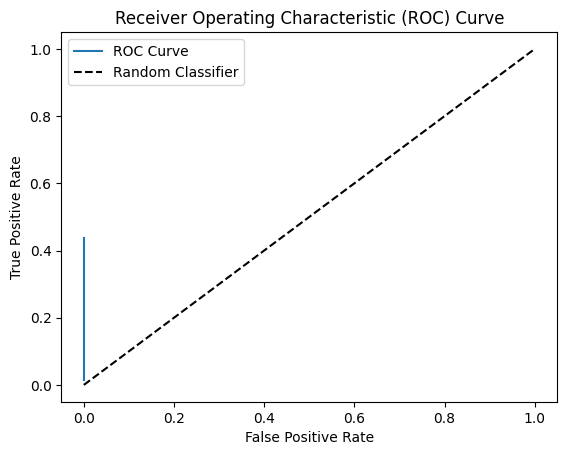

In [46]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_true_binary = label_encoder.fit_transform(y_true)

draw_roc_curve(y_true_binary, y_scores)
# print((y_true_binary), (y_true))

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
cr = classification_report(y_test, final_model.predict(X_test))
print(cr)

              precision    recall  f1-score   support

        alaa       1.00      1.00      1.00         4
     aya amr       1.00      1.00      1.00         7
   aya sameh       1.00      1.00      1.00         6
        ehab       1.00      1.00      1.00         4
      salman       1.00      1.00      1.00        10

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



In [ ]:
def predictor(image_path, mean_face, eigvecs):
    gray_img = cv2.imread(image_path,0)
    face = face_detection(gray_img)
    pixel_values = []
    
    for (x, y, w, h) in face:
        face_img = gray_img[y:y+h, x:x+w]
        face_img = cv2.resize(face_img, (100,100))
        gray_pixels = face_img.flatten().tolist()
        
    pixel_values.append(gray_pixels)
    
    pixel_values = pd.DataFrame(pixel_values)
    
    X = np.array(pixel_values).reshape(len((pixel_values)), -1).astype(np.float64)
    
    X = X-mean_face
    X_pca = np.dot(X,eigvecs.T)
    
    pred = final_model.predict(X_pca)
    
    print(pred)


In [ ]:
predictor("test/IMG-20230515-WA0048.jpg", mean_face, eigvecs)

['aya sameh']


[[196 236 262 262]]


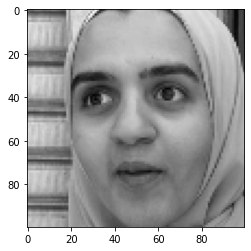

In [ ]:
gray_img = cv2.imread("test/IMG-20230515-WA0048.jpg",0)
face = face_detection(gray_img)
print(face)
counter = 0
for (x, y, w, h) in face:
    face_img = gray_img[y:y+h, x:x+w]
    face_img = cv2.resize(face_img, (100,100))
    plt.imshow(face_img, cmap="gray")
    counter+=1
    if counter == 2 :
        break

In [ ]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(final_model, f)